In [1]:
%%capture
!mkdir data
!wget https://github.com/mannefedov/compling_nlp_hse_course/raw/master/data/lenta.txt.zip -P data
!unzip -o data/lenta.txt.zip -d data/
!pip install -U nltk

In [2]:
import gensim
import numpy as np
import re
from collections import Counter

import nltk
nltk.download('punkt_tab')
nltk.download('stopwords')
from nltk import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
russian_stopwords = set(stopwords.words('russian'))
corpus = open('data/lenta.txt').read()

## Задание 1.

Посчитайте частоты для 5-грамм в корпусе lenta.txt. двумя способами:  
1) lenta.txt -> sent_tokenize (russian) -> word_tokenize -> ngrammer  
2) lenta.txt -> word_tokene(preserve_line=True) - ngrammer  
    
Проанализируйте топ-20 самых частотных нграмм и проверьте есть ли различия?

In [4]:
# удаляет знаки пунктуации и приводит к нижнему регистру
def clean_tokenized_sentences(tokenized_sentences):
    return [[token.lower() for token in sentence if not re.match('\W+', token)]
            for sentence in tokenized_sentences]

In [5]:
def ngrammer(tokens, n=2, stops=set()):
    ngrams = []
    tokens = [token for token in tokens if token not in stops]
    for i in range(0,len(tokens)-n+1):
        ngrams.append(' '.join(tokens[i:i+n]))
    return ngrams

In [6]:
def get_ngram_counts(tokenized_sentences, n=2, stops=set()):
    ngram_counts = Counter()
    for sentence in tokenized_sentences:
        ngram_counts.update(ngrammer(sentence, n, stops))
    return ngram_counts

In [7]:
## method 1
sentences = sent_tokenize(corpus, language='russian')
tokenized_sentences = [word_tokenize(sentence) for sentence in sentences]
tokenized_sentences = clean_tokenized_sentences(tokenized_sentences)
get_ngram_counts(tokenized_sentences, n=5).most_common(20)

[('риа новости со ссылкой на', 400),
 ('сообщает риа новости со ссылкой', 320),
 ('как сообщили риа новости в', 196),
 ('как сообщает риа новости со', 149),
 ('сообщает интерфакс со ссылкой на', 142),
 ('сообщает итар-тасс со ссылкой на', 118),
 ('об этом риа новости сообщили', 113),
 ('об этом сообщает риа новости', 104),
 ('этом риа новости сообщили в', 99),
 ('со ссылкой на источники в', 93),
 ('сообщили риа новости в пресс-службе', 88),
 ('группировки войск на северном кавказе', 84),
 ('как сообщает интерфакс со ссылкой', 83),
 ('объединенной группировки войск на северном', 83),
 ('новости со ссылкой на пресс-службу', 76),
 ('эхо москвы со ссылкой на', 76),
 ('этом сообщает риа новости со', 75),
 ('в связи с тем что', 70),
 ('по борьбе с организованной преступностью', 66),
 ('как сообщает итар-тасс со ссылкой', 58)]

In [8]:
## method 2
tokenized_corpus = [word_tokenize(corpus, preserve_line=True)]
tokenized_corpus = clean_tokenized_sentences(tokenized_corpus)
get_ngram_counts(tokenized_corpus, n=5).most_common(20)

[('риа новости со ссылкой на', 400),
 ('сообщает риа новости со ссылкой', 320),
 ('как сообщили риа новости в', 196),
 ('как сообщает риа новости со', 149),
 ('сообщает интерфакс со ссылкой на', 142),
 ('сообщает итар-тасс со ссылкой на', 118),
 ('об этом риа новости сообщили', 113),
 ('об этом сообщает риа новости', 104),
 ('этом риа новости сообщили в', 99),
 ('со ссылкой на источники в', 93),
 ('сообщили риа новости в пресс-службе', 88),
 ('как сообщает интерфакс со ссылкой', 83),
 ('объединенной группировки войск на северном', 83),
 ('эхо москвы со ссылкой на', 77),
 ('новости со ссылкой на пресс-службу', 76),
 ('этом сообщает риа новости со', 75),
 ('в связи с тем что', 70),
 ('как сообщает итар-тасс со ссылкой', 58),
 ('группировки войск на северном кавказе', 57),
 ('по борьбе с организованной преступностью', 55)]

В результате способа 2 уменьшилось количество 5-грамм "группировки войск на северном кавказе" и "по борьбе с организованной преступностью"; количество 5-граммы "эхо москвы со ссылкой на" увеличилось на 1.

Уменьшение количества 5-грамм вызвано тем, что word_tokenize отделяет точку только от слова, находящегося в списке последним ([документация](https://www.nltk.org/api/nltk.tokenize.destructive.html#nltk.tokenize.destructive.NLTKWordTokenizer)). Следовательно, если word_tokenize подается на вход весь корпус сразу, в список попадают новые токены с точками на конце и идут в учет разных 5-грамм.

Увеличение вхождений одной из 5-грамм на 1 объяснимо тем, что первая часть "нового" вхождения находится в одном предложении, а вторая - в следующем, и между ними нет точки (или до точки еще какой-то знак препинания).

Гипотеза подтвердилась:

In [9]:
for i in range(len(sentences) - 1):
    cleaned_sent1 = re.sub('[^а-яА-ЯЁё ]+', '', sentences[i].lower())
    cleaned_sent2 = re.sub('[^а-яА-ЯЁё ]+', '', sentences[i+1].lower())
    if cleaned_sent1.endswith('эхо москвы') and cleaned_sent2.startswith('со ссылкой'):
        print(f'Предложение {i}: {sentences[i]}')
        print(f'Предложение {i+1}: {sentences[i+1]}')

Предложение 64063: Видимо, "Манчестеру", который после отъезда в Португалию Петера Шмейхеля никак не определится с основным вратарем, придется поискать стража ворот в другом месте.Пресс-служба Министерства обороны России опровергает информацию, распространенную в среду газетой "Аргументы и факты", о возможной дате начала бомбардировок талибских баз в Афганистане, сообщает "Эхо Москвы".
Предложение 64064: Со ссылкой на источники в Минобороны России газета сообщала о том, что бомбежки могут начаться уже 8 июня - по окончании визита Клинтона в Москву.


In [10]:
test = 'Видимо, "Манчестеру", который после отъезда в Португалию Петера Шмейхеля никак не определится с основным вратарем, придется поискать стража ворот в другом месте. Пресс-служба Министерства обороны России опровергает информацию, распространенную в среду газетой "Аргументы и факты", о возможной дате начала бомбардировок талибских баз в Афганистане, сообщает "Эхо Москвы".\nСо ссылкой на источники в Минобороны России газета сообщала о том, что бомбежки могут начаться уже 8 июня - по окончании визита Клинтона в Москву.'
print(word_tokenize(test, preserve_line=True))

['Видимо', ',', '``', 'Манчестеру', "''", ',', 'который', 'после', 'отъезда', 'в', 'Португалию', 'Петера', 'Шмейхеля', 'никак', 'не', 'определится', 'с', 'основным', 'вратарем', ',', 'придется', 'поискать', 'стража', 'ворот', 'в', 'другом', 'месте.', 'Пресс-служба', 'Министерства', 'обороны', 'России', 'опровергает', 'информацию', ',', 'распространенную', 'в', 'среду', 'газетой', '``', 'Аргументы', 'и', 'факты', "''", ',', 'о', 'возможной', 'дате', 'начала', 'бомбардировок', 'талибских', 'баз', 'в', 'Афганистане', ',', 'сообщает', '``', 'Эхо', 'Москвы', "''", '.', 'Со', 'ссылкой', 'на', 'источники', 'в', 'Минобороны', 'России', 'газета', 'сообщала', 'о', 'том', ',', 'что', 'бомбежки', 'могут', 'начаться', 'уже', '8', 'июня', '-', 'по', 'окончании', 'визита', 'Клинтона', 'в', 'Москву', '.']


## Задание 2.

Найдите какую-то инетересную (по вашему мнению) закономерность на https://books.google.com/ngrams/ для русского языка (с 1990 по 2022)

Вставьте сюда скриншот

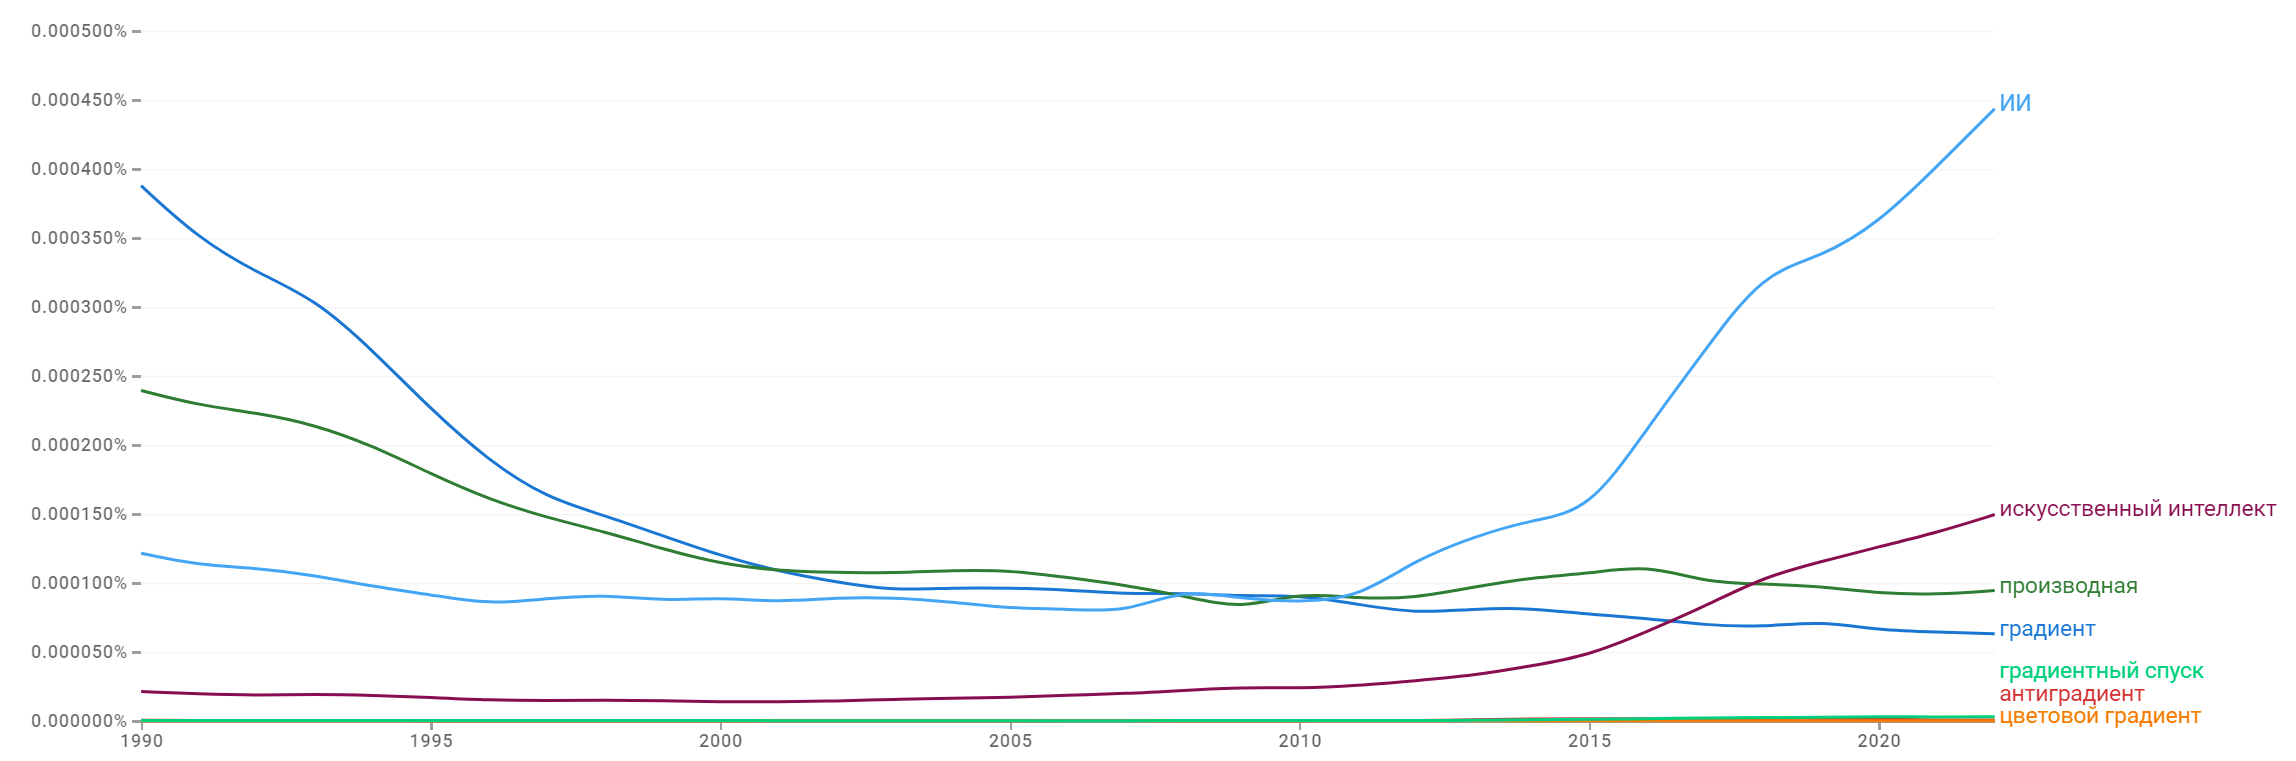

## Заданиe 3

Когда мы разбирали PMI мы использовали такую функцию:

In [11]:
def scorer_simple(word_count_a, word_count_b, bigram_count, *args):
    try:
        score = bigram_count/((word_count_a+word_count_b))
    except ZeroDivisionError:
        return 0
    return score

Но если вы посмотрите на определение в википедии, то увидите, что формула немного другая ![](https://wikimedia.org/api/rest_v1/media/math/render/svg/094243d23c19d2d032f6bb26c4dc4f47d98d32f8)

Перепишите функцию, чтобы она точно соответствовала этому определению. Расчитайте PMI для всех биграммов также как мы делали в семинаре с помощью функции score_bigrams используя изначальный scorer и обновленный. Посмотрите есть ли разница в топ-10 биграммов. Подумайте почему результаты совпадают/отличаются?

*Подсказка: для вероятностей можно поделить на количество слов в корпусе

In [12]:
def scorer_pmi(word_count_a, word_count_b, bigram_count, total_word_count, scorer_type='simple'):
    try:
      if scorer_type == 'simple':
          score = bigram_count / (word_count_a + word_count_b)
      elif scorer_type == 'standard':
          prob_b_given_a = bigram_count / word_count_a
          prob_b = word_count_b / total_word_count
          score = np.log2(prob_b_given_a / prob_b)
      else:
          raise ValueError('Unknown scorer_type')
    except ZeroDivisionError:
        return 0
    return score

In [13]:
def collect_stats(corpus, stops):
    unigrams = Counter()
    bigrams = Counter()

    for sent in corpus:
        # теперь не будем учитывать стоп-слова, в отличие от 5-грамм
        unigrams.update([token for token in sent if token not in stops])
        bigrams.update(ngrammer(sent, 2, stops))

    return unigrams, bigrams

In [14]:
def score_bigrams(unigrams, bigrams, scorer_type='simple', max_threshold=100000, min_threshold=-100000):
    # посчитаем метрику для каждого нграмма
    bigram2score = Counter()
    additional_info = {}
    corpus_len = sum(unigrams.values())

    for bigram in bigrams:
        word_a, word_b = bigram.split()
        score = scorer_pmi(
            unigrams[word_a], unigrams[word_b],
            bigrams[bigram], corpus_len,
            scorer_type=scorer_type
        )

        # если метрика выше порога, добавляем в словарик
        if score > min_threshold and score < max_threshold:
            bigram2score[bigram] = score
            additional_info[bigram] = f'Unigrams A: {unigrams[word_a]}; Unigrams B: {unigrams[word_b]}; Bigrams: {bigrams[bigram]}'

    return bigram2score, additional_info

In [15]:
unigrams, bigrams = collect_stats(tokenized_sentences, russian_stopwords)

Результаты идентичны для биграмм, каждое из слов в которых встречается только один раз:

In [16]:
bigram2score, additional_info = score_bigrams(unigrams, bigrams, scorer_type='simple')
for item in bigram2score.most_common(10):
    print(item, additional_info[item[0]])

('сопоцкина друскеник', 0.5) Unigrams A: 1; Unigrams B: 1; Bigrams: 1
('неприятель приблизившись', 0.5) Unigrams A: 1; Unigrams B: 1; Bigrams: 1
('саноку обстреливалась', 0.5) Unigrams A: 1; Unigrams B: 1; Bigrams: 1
('м.ю лермонтова', 0.5) Unigrams A: 1; Unigrams B: 1; Bigrams: 1
('австрийский аэроплан', 0.5) Unigrams A: 1; Unigrams B: 1; Bigrams: 1
('показывался аэроплан-птица', 0.5) Unigrams A: 1; Unigrams B: 1; Bigrams: 1
('das ist', 0.5) Unigrams A: 1; Unigrams B: 1; Bigrams: 1
('ist nesteroff', 0.5) Unigrams A: 1; Unigrams B: 1; Bigrams: 1
('песнь нестерове', 0.5) Unigrams A: 1; Unigrams B: 1; Bigrams: 1
('могучий унесся', 0.5) Unigrams A: 1; Unigrams B: 1; Bigrams: 1


In [17]:
bigram2score, additional_info = score_bigrams(unigrams, bigrams, scorer_type='standard')
for item in bigram2score.most_common(10):
    print(item, additional_info[item[0]])

('сопоцкина друскеник', 20.104850820306964) Unigrams A: 1; Unigrams B: 1; Bigrams: 1
('неприятель приблизившись', 20.104850820306964) Unigrams A: 1; Unigrams B: 1; Bigrams: 1
('саноку обстреливалась', 20.104850820306964) Unigrams A: 1; Unigrams B: 1; Bigrams: 1
('м.ю лермонтова', 20.104850820306964) Unigrams A: 1; Unigrams B: 1; Bigrams: 1
('австрийский аэроплан', 20.104850820306964) Unigrams A: 1; Unigrams B: 1; Bigrams: 1
('показывался аэроплан-птица', 20.104850820306964) Unigrams A: 1; Unigrams B: 1; Bigrams: 1
('das ist', 20.104850820306964) Unigrams A: 1; Unigrams B: 1; Bigrams: 1
('ist nesteroff', 20.104850820306964) Unigrams A: 1; Unigrams B: 1; Bigrams: 1
('песнь нестерове', 20.104850820306964) Unigrams A: 1; Unigrams B: 1; Bigrams: 1
('могучий унесся', 20.104850820306964) Unigrams A: 1; Unigrams B: 1; Bigrams: 1


Поставим скор, который получается у таких биграмм, максимальным трешхолдом:

In [18]:
bigram2score, additional_info = score_bigrams(unigrams, bigrams, scorer_type='simple', max_threshold=0.5)
for item in bigram2score.most_common(10):
    print(item, additional_info[item[0]])

('риа новости', 0.49289032803040966) Unigrams A: 3517; Unigrams B: 3586; Bigrams: 3501
('dow jones', 0.49122807017543857) Unigrams A: 28; Unigrams B: 29; Bigrams: 28
('wall street', 0.49056603773584906) Unigrams A: 52; Unigrams B: 54; Bigrams: 52
('exit polls', 0.49019607843137253) Unigrams A: 26; Unigrams B: 25; Bigrams: 25
('норильский никель', 0.48) Unigrams A: 25; Unigrams B: 25; Bigrams: 24
('пит сампрас', 0.4782608695652174) Unigrams A: 11; Unigrams B: 12; Bigrams: 11
('мысе канаверал', 0.47619047619047616) Unigrams A: 10; Unigrams B: 11; Bigrams: 10
('брюшным тифом', 0.47619047619047616) Unigrams A: 10; Unigrams B: 11; Bigrams: 10
('саудовской аравии', 0.47560975609756095) Unigrams A: 41; Unigrams B: 41; Bigrams: 39
('саудовская аравия', 0.47368421052631576) Unigrams A: 18; Unigrams B: 20; Bigrams: 18


In [19]:
bigram2score, additional_info = score_bigrams(unigrams, bigrams, scorer_type='standard', max_threshold=20.104850820306964)
for item in bigram2score.most_common(10):
    print(item, additional_info[item[0]])

('отступлением германцев', 19.104850820306964) Unigrams A: 2; Unigrams B: 1; Bigrams: 1
('перемышля саноку', 19.104850820306964) Unigrams A: 2; Unigrams B: 1; Bigrams: 1
('батареей бежала', 19.104850820306964) Unigrams A: 1; Unigrams B: 2; Bigrams: 1
('парки обоз', 19.104850820306964) Unigrams A: 2; Unigrams B: 1; Bigrams: 1
('желтиева галиции', 19.104850820306964) Unigrams A: 1; Unigrams B: 2; Bigrams: 1
('расположением австрийский', 19.104850820306964) Unigrams A: 2; Unigrams B: 1; Bigrams: 1
('вольно паривший', 19.104850820306964) Unigrams A: 2; Unigrams B: 1; Bigrams: 1
('нестерове безбрежности', 19.104850820306964) Unigrams A: 1; Unigrams B: 2; Bigrams: 1
('доныне.так птице', 19.104850820306964) Unigrams A: 1; Unigrams B: 2; Bigrams: 1
('легкокрылый темные', 19.104850820306964) Unigrams A: 1; Unigrams B: 2; Bigrams: 1


Новый топ-10 получается другой: принципиальное различие двух метрик заключается в том, что в варианте ```simple``` количество вхождений биграммы делится на сумму вхождений каждого из слов, а в варианте ```standard``` - на их произведение. Посмотрим на топ-1 для ```simple``` - настолько большое количество вхождений каждого из слов обеспечивает большой знаменатель в метрике ```standard```:

3501 / (3517 * 3586) = 0.0002775936.

Идеальная ситуация (не считая той, когда оба слова уникальны и, следовательно, числитель и знаменатель равны) - когда знаменатель больше числителя на 1. Это возможно только в двух случаях:

Unigrams A: 2; Unigrams B: 1; Bigrams: 1

Unigrams A: 1; Unigrams B: 2; Bigrams: 1

## Задание 4*

Обновите функцию получившуюся в предыдущем задании так, чтобы вместо произведения/деления вероятностей использовались сложение и вычитание логирифмов.

In [20]:
def scorer_pmi(word_count_a, word_count_b, bigram_count, total_word_count, scorer_type='simple'):
    try:
      if scorer_type == 'simple':
          score = bigram_count / (word_count_a + word_count_b)
      elif scorer_type == 'standard':
          prob_b_given_a = bigram_count / word_count_a
          prob_b = word_count_b / total_word_count
          score = np.log2(prob_b_given_a) - np.log2(prob_b)
      else:
          raise ValueError('Unknown scorer_type')
    except ZeroDivisionError:
        return 0
    return score

In [21]:
bigram2score, additional_info = score_bigrams(unigrams, bigrams, scorer_type='standard')
for item in bigram2score.most_common(10):
    print(item, additional_info[item[0]])

('сопоцкина друскеник', 20.104850820306964) Unigrams A: 1; Unigrams B: 1; Bigrams: 1
('неприятель приблизившись', 20.104850820306964) Unigrams A: 1; Unigrams B: 1; Bigrams: 1
('саноку обстреливалась', 20.104850820306964) Unigrams A: 1; Unigrams B: 1; Bigrams: 1
('м.ю лермонтова', 20.104850820306964) Unigrams A: 1; Unigrams B: 1; Bigrams: 1
('австрийский аэроплан', 20.104850820306964) Unigrams A: 1; Unigrams B: 1; Bigrams: 1
('показывался аэроплан-птица', 20.104850820306964) Unigrams A: 1; Unigrams B: 1; Bigrams: 1
('das ist', 20.104850820306964) Unigrams A: 1; Unigrams B: 1; Bigrams: 1
('ist nesteroff', 20.104850820306964) Unigrams A: 1; Unigrams B: 1; Bigrams: 1
('песнь нестерове', 20.104850820306964) Unigrams A: 1; Unigrams B: 1; Bigrams: 1
('могучий унесся', 20.104850820306964) Unigrams A: 1; Unigrams B: 1; Bigrams: 1


In [22]:
bigram2score, additional_info = score_bigrams(unigrams, bigrams, scorer_type='standard', max_threshold=20.104850820306964)
for item in bigram2score.most_common(10):
    print(item, additional_info[item[0]])

('отступлением германцев', 19.104850820306964) Unigrams A: 2; Unigrams B: 1; Bigrams: 1
('перемышля саноку', 19.104850820306964) Unigrams A: 2; Unigrams B: 1; Bigrams: 1
('батареей бежала', 19.104850820306964) Unigrams A: 1; Unigrams B: 2; Bigrams: 1
('парки обоз', 19.104850820306964) Unigrams A: 2; Unigrams B: 1; Bigrams: 1
('желтиева галиции', 19.104850820306964) Unigrams A: 1; Unigrams B: 2; Bigrams: 1
('расположением австрийский', 19.104850820306964) Unigrams A: 2; Unigrams B: 1; Bigrams: 1
('вольно паривший', 19.104850820306964) Unigrams A: 2; Unigrams B: 1; Bigrams: 1
('нестерове безбрежности', 19.104850820306964) Unigrams A: 1; Unigrams B: 2; Bigrams: 1
('доныне.так птице', 19.104850820306964) Unigrams A: 1; Unigrams B: 2; Bigrams: 1
('легкокрылый темные', 19.104850820306964) Unigrams A: 1; Unigrams B: 2; Bigrams: 1


## Задание 5

Исследуйте gensim.models.Phrases. Проверьте сколько дефолтных scoring функций есть в этом классе. Попробуйте все доступные по умолчанию scoring функции и попробуйте настраивать для них значение threshold и min_count. Попробуйте сделать так, чтобы собиралось как можно больше нграммов. Попробуйте строить последовательность gensim.models.Phrases, чтобы строить более длинные нграммы

scoring функции:

```npmi```, normalized pointwise mutual information, от -1 до 1

"threshold should be between -1 and 1 for npmi scoring"

```default```, метрика из статьи про word2vec, значение может быть отрицательным

"threshold should be positive for default scoring"

In [23]:
min_counts = [1, 2, 5, 10, 20, 50]
thresholds_normalized = [-0.5, -0.25, 0, 0.25, 0.5]
thresholds_default = [10, 25, 50, 100, 250]

In [24]:
for min_count in min_counts:
    for threshold in thresholds_normalized:
        ph = gensim.models.Phrases(
            tokenized_sentences,
            min_count=min_count,
            threshold=threshold,
            scoring='npmi'
        )
        p = gensim.models.phrases.Phraser(ph)
        print(f'scoring: npmi; min_count: {min_count}; threshold: {threshold}')
        print(p[tokenized_sentences[39]])
        print(p[tokenized_sentences[1258]])
        print(p[tokenized_sentences[16743]])
        print()

scoring: npmi; min_count: 1; threshold: -0.5
['gazeta_ru', 'подробно_писала', 'о_том', 'что_финансирование', 'программы_мир', 'закрыто_но', 'конструкторы_не', 'спешат_топить', 'ее_в', 'тихом_океане', 'надеясь_на', 'изыскание_внебюджетных', 'средств.они_надеются', 'что_правительство', 'оплатит_финальную', 'экспедицию_на', 'мир_в', 'феврале_или', 'марте_2000', 'года']
['однако_власти', 'пока_не', 'могут_официально', 'подтвердить_данные', 'которые_сообщил', 'о_себе', 'задержанный_так', 'как_никаких', 'записей_о', 'его_местожительстве', 'и_прошлой', 'работе_нет.сегодня', 'после_1', 'часа_ночи', 'дежурная_смена', 'цупа_послаласигнал', 'на_выключение', 'главного_бортового', 'компьютера_станции', 'мир_результате', 'этого_работа', 'всех_элементов', 'системы_управления', 'движением_орбитального', 'комплекса_была', 'остановлена']
['по_данным', 'majestic_wine', 'закупки_обычных', 'вин_также', 'превзошли_все', 'ожидания_британцы', 'покупают_вина', 'больше_и', 'более_дорогих', 'сортов_нежели', 'пер

In [25]:
for min_count in min_counts:
    for threshold in thresholds_default:
        ph = gensim.models.Phrases(
            tokenized_sentences,
            min_count=min_count,
            threshold=threshold,
            scoring='default'
        )
        p = gensim.models.phrases.Phraser(ph)
        print(f'scoring: default; min_count: {min_count}; threshold: {threshold}')
        print(p[tokenized_sentences[39]])
        print(p[tokenized_sentences[1258]])
        print(p[tokenized_sentences[16743]])
        print()

scoring: default; min_count: 1; threshold: 10
['gazeta_ru', 'подробно', 'писала_о', 'том_что', 'финансирование_программы', 'мир', 'закрыто', 'но', 'конструкторы', 'не_спешат', 'топить', 'ее', 'в', 'тихом_океане', 'надеясь', 'на', 'изыскание', 'внебюджетных', 'средств.они', 'надеются_что', 'правительство', 'оплатит', 'финальную', 'экспедицию_на', 'мир', 'в_феврале', 'или', 'марте_2000', 'года']
['однако', 'власти', 'пока_не', 'могут', 'официально', 'подтвердить', 'данные', 'которые', 'сообщил', 'о_себе', 'задержанный', 'так_как', 'никаких', 'записей', 'о', 'его', 'местожительстве', 'и', 'прошлой', 'работе', 'нет.сегодня', 'после', '1', 'часа_ночи', 'дежурная', 'смена', 'цупа', 'послаласигнал', 'на', 'выключение', 'главного', 'бортового', 'компьютера', 'станции_мир', 'результате', 'этого', 'работа_всех', 'элементов_системы', 'управления', 'движением', 'орбитального_комплекса', 'была_остановлена']
['по_данным', 'majestic_wine', 'закупки', 'обычных', 'вин', 'также', 'превзошли', 'все_ожида

Последовательность из трех gensim.models.Phrases (максимум 4-граммы):

In [26]:
ph = gensim.models.Phrases(tokenized_sentences,  min_count=1, threshold=1.0, scoring='default')
p = gensim.models.phrases.Phraser(ph)

ph2 = gensim.models.Phrases(p[tokenized_sentences],  min_count=1, threshold=1.0, scoring='default')
p2 = gensim.models.phrases.Phraser(ph2)

ph3 = gensim.models.Phrases(p2[tokenized_sentences],  min_count=1, threshold=1.0, scoring='default')
p3 = gensim.models.phrases.Phraser(ph3)

In [27]:
p3[p2[p[tokenized_sentences[38]]]]

['журнал_нива',
 'от_20',
 'сентября_1914',
 'годакак',
 'стало_известно',
 'агентству',
 'ассошиэйтед',
 'пресс',
 'экипаж',
 'последней',
 'экспедиции_на_станцию_мир',
 'считает_ее',
 'способной',
 'выйти_из-под',
 'контроля.командир',
 'виктор',
 'афанасьев',
 'сказал',
 'мы_чувствуем',
 'себя_хорошо',
 'но',
 'грустим',
 'что',
 'оставили',
 'станцию',
 'летать_в',
 'беспилотном',
 'режиме']

In [28]:
p3[p2[p[tokenized_sentences[1238]]]]

['российский',
 'следователь',
 'пояснил_что',
 'по',
 'швейцарским',
 'законам',
 'без',
 'решения_суда',
 'правоохранительные_органы',
 'не_имеют_права',
 'не_только',
 'выдать',
 'но_даже',
 'показывать',
 'следователям',
 'изъятые_документы',
 'если',
 'против_этого',
 'возражают',
 'свидетели_и',
 'адвокаты',
 'тех_чьи',
 'интересы',
 'затрагиваются',
 'в_ходе_расследования']

In [29]:
p3[p2[p[tokenized_sentences[16343]]]]

['если_президент',
 'все_же',
 'подпишет',
 'его',
 'закон',
 'вступит_в',
 'силу_с_1_января',
 '2000',
 'года.мосгоризбирком',
 'утвердил',
 'образец',
 'избирательного_бюллетеня_по_выборам',
 'мэра_и_вице-мэра_столицы']